In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

# 1 Generating blob labels
- We aim to generate a tensor of blob labels that is size `shape` in all dimensions
- The returned label tensor is composed of integers with shape (D, H, W)

In [92]:
import cornucopia as cc
import matplotlib.pyplot as plt
from SynthShapes.shapes import MultiLobedBlobSampler
import torch
from torch import nn

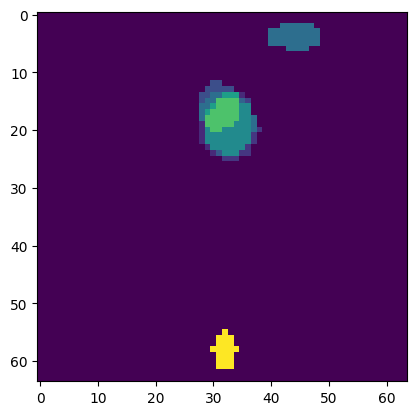

In [3]:
blob_labels, blob_mask = MultiLobedBlobSampler(shape=64, return_mask=True)()
plt.imshow(blob_labels[0, 32].cpu())

# 2 Augmenting blobs into background

In [4]:
import cornucopia as cc
import matplotlib.pyplot as plt
from SynthShapes.shapes import MultiLobeBlobAugmentation
import torch

## 2.1 Generating background
We begin by generating the background labels of shape (1, 64, 64, 64) into which we will blend the blobs.

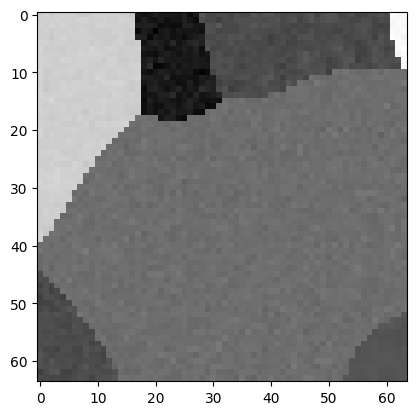

In [18]:
base = torch.randn((1, 64, 64, 64))
base = cc.RandomSmoothLabelMap()(base)
base = cc.RandomGaussianMixtureTransform()(base)
plt.imshow(base[0, 32].cpu(), cmap='gray')

## 2.2 (OPTIONAL) Define the intensity augmentation for the blobs
We will now optionally define a transformation which will be applied to **only** blobs. This is important to make sure the blobs have some texture.

In [88]:
augmentation = torch.nn.Sequential(
    cc.RandomGaussianMixtureTransform(mu=1, sigma=1),
)

## 2.3 Augment and view the base tensor & blob mask
We now use SynthShapes to generate and blend the blobs into the base tensor we made earlier

tensor([-0.7628, -0.3875, -0.2858,  ...,  2.9560,  2.9724,  3.7688],
       device='cuda:0')


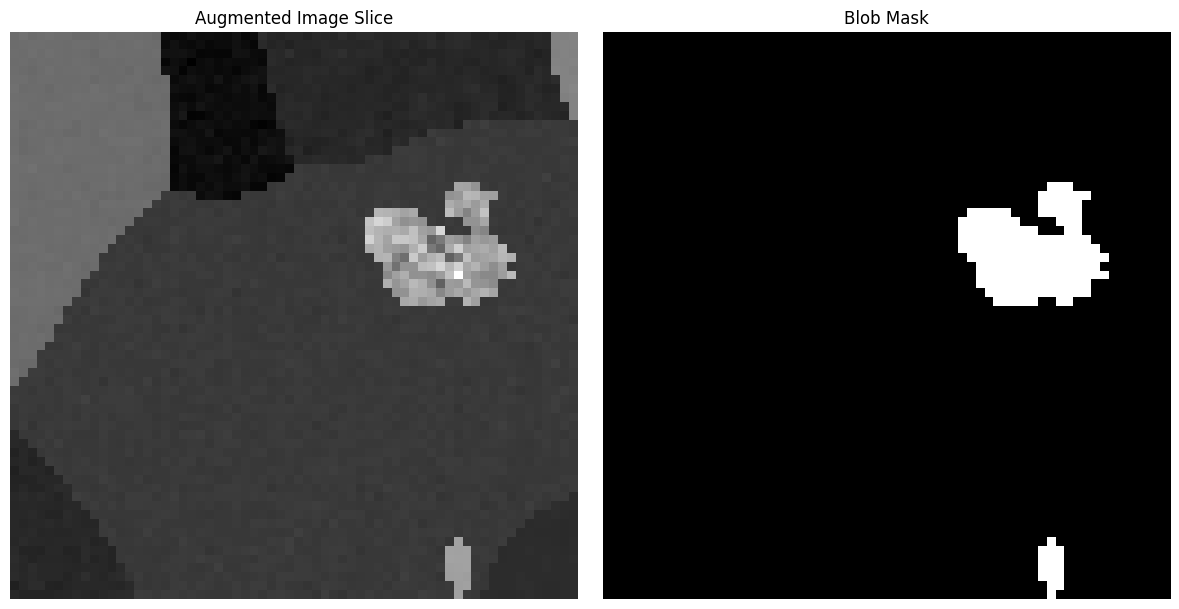

In [111]:
augmented_base, mask = MultiLobeBlobAugmentation(
    shape=64,
    alpha=cc.Uniform(0.5, 0.75),
    intensity_shift=cc.Uniform(2, 20),
    augmentation=augmentation,
    return_mask=True
    )(base)

# Transform histogram
augmented_base = cc.QuantileTransform(
    vmin=0.1,
    vmax=0.9,
    pmin=0.1,
    pmax=0.9
    )(augmented_base)

print(torch.unique(augmented_base))

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Augmented image slice
ax1.imshow(augmented_base[0, 32].cpu(), cmap='gray')
ax1.set_title("Augmented Image Slice")
ax1.axis('off')
# Blob mask
ax2.imshow(mask[0, 32].cpu(), cmap='gray')
ax2.set_title("Blob Mask")
ax2.axis('off')
# Display fig
plt.tight_layout()
plt.show()

## 2.4 Visualize intensity distribution
Now let's visualize the distribution of intensities in our synthesized image.

tensor([-0.7628, -0.3875, -0.2858,  ...,  2.9560,  2.9724,  3.7688],
       device='cuda:0')


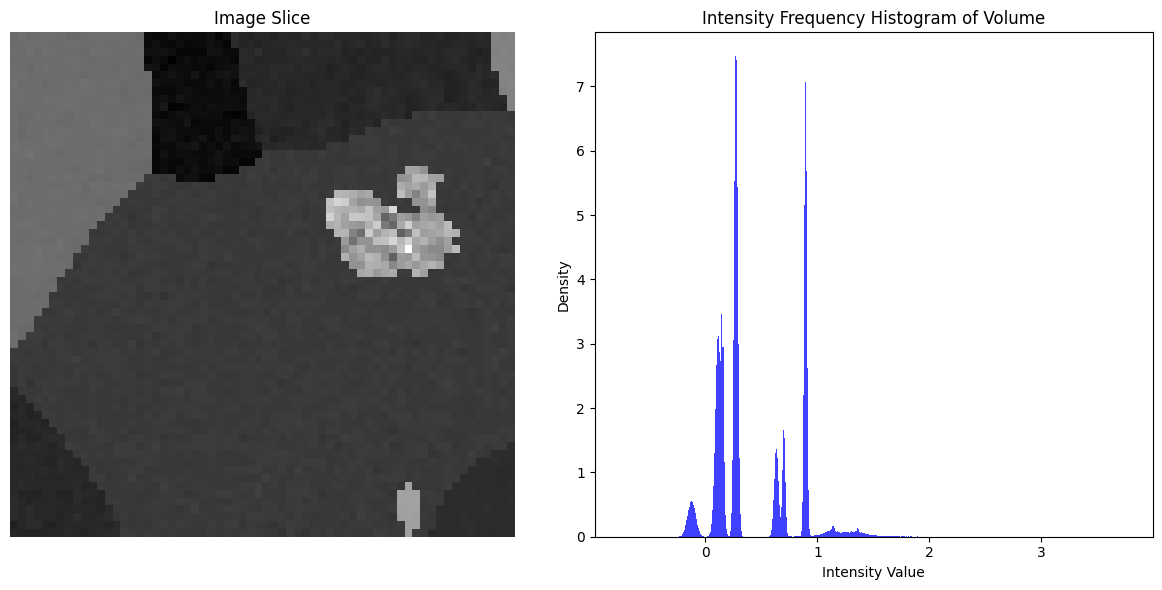

In [112]:
print(torch.unique(augmented_base))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Image
ax1.imshow(augmented_base[0, 32].cpu(), cmap='gray')
ax1.set_title("Image Slice")
ax1.axis('off')

# Histogram
ax2.hist(augmented_base.flatten().cpu().numpy(), bins=500, density=True, alpha=0.75, color='b')
ax2.set_title("Intensity Frequency Histogram of Volume")
ax2.set_xlabel("Intensity Value")
ax2.set_ylabel("Density")

# Display fig
plt.tight_layout()
plt.show()